In [39]:
import pandas as pd
import numpy as np

In [40]:
dataset_dir = 'datasets'
file = 'news_traindata' # 'WELFake_Dataset.csv'
nrows = 110000 * 0.9
vocab_file = f'vocabs/vokab_{file}_{nrows}.pkl'
pri_model_file = f"models/simple_model_{file}_{nrows}.pth"
sec_model_file = f"models/stage2_model_{file}_{nrows}.pth"

df = pd.read_csv(f'{dataset_dir}/{file}.csv', encoding='utf-8', nrows=nrows)
df = df.dropna()
df = df[df['label'] == 1]

df.head()

,type,title,content,label
0,satire,"Massive Incoming Comet, Earthquake and Tsunami...",It has been reported that there is a disaster ...,1
1,political,A Whisper at the University of Houston-Downtow...,"The newscaster said, ""UHD student is trying to...",1
2,clickbait,"TV show forces babies to cross-dress, pushes f...","NewsGender\n\nISLE OF WIGHT, England, August 2...",1
3,political,National Review Online,Cliffhanger\n\nWright and political wrongs.\n\...,1
4,clickbait,11 Reasons Why Liberals And Progressives Are M...,13415 SHARES Facebook Twitter Reddit Stumbleup...,1


In [41]:
import os
import pickle
from torchtext.data.utils import get_tokenizer
from collections import Counter

MAX_VOCAB = 25000
special_tokens = ['<unk>', '<pad>']
tokenizer = get_tokenizer('basic_english')


if os.path.exists(vocab_file):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    print("Vocabulary loaded from 'vocab.pkl'.")

else:
    print("Unable to load vocab.")
    


Vocabulary loaded from 'vocab.pkl'.


In [42]:
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

MAX_LENGTH = 2048

# Label encode the 'type' column
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

NUM_CLASSES = len(le.classes_)  # Number of unique classes

encoded_texts_and_labels = []
for text, label in zip(df['content'], df['type_encoded']):
    if pd.notna(text):
        encoded = [vocab[token] for token in tokenizer(text)]
        
        if len(encoded) <= MAX_LENGTH:
            encoded_texts_and_labels.append((torch.tensor(encoded, dtype=torch.long), label))

# Separate encoded texts and labels
encoded_texts = [item[0] for item in encoded_texts_and_labels]
label_indices = torch.tensor([item[1] for item in encoded_texts_and_labels], dtype=torch.long)

# Create one-hot encoded labels
labels = F.one_hot(label_indices, num_classes=NUM_CLASSES).float()

# Pad sequences
padded_texts = pad_sequence(encoded_texts, batch_first=True, padding_value=vocab['<pad>'])

print(f"Filtered texts: {len(padded_texts)}, Labels: {labels.shape}")


Filtered texts: 86757, Labels: torch.Size([86757, 10])


In [43]:
df.head()
print(labels[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


In [44]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_val, y_train, y_val = train_test_split(padded_texts, labels, test_size=0.1)

train_ds = NewsDataset(X_train, y_train)
val_ds = NewsDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0)

In [45]:
# ===== ADD THESE IMPORTS =====
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [46]:
import importlib
import mulstage_model
importlib.reload(mulstage_model)
from mulstage_model import CNN_BiLSTM, FakeNewsClassifier
import torch.nn as nn

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
sec_model = FakeNewsClassifier(input_dim= ((100 * 3) + (128 * 2)), num_classes=NUM_CLASSES)
sec_model.to(device)
print("Model architecture:")
print(sec_model)

pri_model = CNN_BiLSTM(vocab=vocab, vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=11, pad_idx=vocab['<pad>'])
pri_model.to(device)

#pri_model.load_state_dict(torch.load(f"model_news_data_bin_{nrows}.pth", map_location=torch.device('cpu')))
model_path = os.path.abspath(pri_model_file)
pri_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

print("done constructing model")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sec_model.parameters(), lr=1e-3)   

print("done constructing optimizer")
import torch
from tqdm import tqdm

# Modify the extract_features function to collect all features
def precompute_features(model, dataloader):
    """
    Precompute features from the primary model for all samples in the dataloader
    Returns:
        all_features: tensor of shape [num_samples, feature_dim]
        all_labels: tensor of shape [num_samples]
    """
    model.eval()  # Set model to evaluation mode
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in tqdm(dataloader, desc="Precomputing features"):
            xb, yb = xb.to(device), yb.to(device)
            features = model.extract_features(xb)
            all_features.append(features)
            all_labels.append(yb)
    
    # Concatenate all features and labels
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_features, all_labels

# Create a dataset class for precomputed features
class PrecomputedFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Precompute features for training and validation sets
print("Precomputing features for training set...")
train_features, train_labels = precompute_features(pri_model, train_dl)
print(f"Training features shape: {train_features.shape}")

print("Precomputing features for validation set...")
val_features, val_labels = precompute_features(pri_model, val_dl)
print(f"Validation features shape: {val_features.shape}")

# Create datasets and dataloaders for precomputed features
train_feature_dataset = PrecomputedFeatureDataset(train_features, train_labels)
val_feature_dataset = PrecomputedFeatureDataset(val_features, val_labels)

# Define batch size for the new dataloader (can be different than original)
batch_size = 64  # Adjust according to your needs

train_feature_dl = torch.utils.data.DataLoader(
    train_feature_dataset, 
    batch_size=batch_size,
    shuffle=True
)

val_feature_dl = torch.utils.data.DataLoader(
    val_feature_dataset, 
    batch_size=batch_size,
    shuffle=False
)

# Now modify the training function to use precomputed features
def train_with_precomputed(sec_model, loader):
    sec_model.train()
    total_loss = 0
    
    for features, labels in tqdm(loader, desc="Training", leave=False):
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        preds = sec_model(features)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

# def evaluate_with_precomputed(sec_model, loader):
#     sec_model.eval()
#     total_acc = 0
    
#     with torch.no_grad():
#         for features, labels in loader:
#             features, labels = features.to(device), labels.to(device)
            
#             preds = sec_model(features)
#             preds_class = preds.argmax(dim=1)
#             labels_class = labels.argmax(dim=1)
            
#             total_acc += (preds_class == labels_class).float().mean().item()
    
#     return total_acc / len(loader)

def evaluate_with_confusion_matrix(sec_model, loader):
    sec_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            preds = sec_model(features)
            preds_class = preds.argmax(dim=1)
            labels_class = labels.argmax(dim=1)
            all_preds.extend(preds_class.cpu().numpy())
            all_labels.extend(labels_class.cpu().numpy())
    
    return all_labels, all_preds

def calculate_accuracy(sec_model, loader):
    all_labels, all_preds = evaluate_with_confusion_matrix(sec_model, loader)
    return (np.array(all_labels) == np.array(all_preds)).mean()


Using device: mps
Model architecture:
FakeNewsClassifier(
  (fc1): Linear(in_features=556, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)
done constructing model
done constructing optimizer
Precomputing features for training set...


Precomputing features: 100%|██████████| 2441/2441 [03:44<00:00, 10.87it/s]


Training features shape: torch.Size([78081, 556])
Precomputing features for validation set...


Precomputing features: 100%|██████████| 272/272 [00:27<00:00,  9.84it/s]

Validation features shape: torch.Size([8676, 556])


In [47]:

# Training loop using precomputed features
print("Training with precomputed features")
for epoch in range(200):
    loss = train_with_precomputed(sec_model, train_feature_dl)
    acc = calculate_accuracy(sec_model, val_feature_dl)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Val Acc: {acc:.4f}")


Training with precomputed features


Epoch 10, Loss: 0.4474, Val Acc: 0.8771


Epoch 20, Loss: 0.3917, Val Acc: 0.8736


Epoch 30, Loss: 0.3554, Val Acc: 0.8744


Epoch 40, Loss: 0.3213, Val Acc: 0.8722


Epoch 50, Loss: 0.3034, Val Acc: 0.8741


Epoch 60, Loss: 0.2775, Val Acc: 0.8691


Epoch 70, Loss: 0.2660, Val Acc: 0.8703


Epoch 80, Loss: 0.2490, Val Acc: 0.8688


Epoch 90, Loss: 0.2405, Val Acc: 0.8714


Epoch 100, Loss: 0.2345, Val Acc: 0.8673


Epoch 110, Loss: 0.2274, Val Acc: 0.8673


Epoch 120, Loss: 0.2141, Val Acc: 0.8688


Epoch 130, Loss: 0.2092, Val Acc: 0.8683


Epoch 140, Loss: 0.2089, Val Acc: 0.8632


Epoch 150, Loss: 0.1989, Val Acc: 0.8658


Epoch 160, Loss: 0.1974, Val Acc: 0.8631


Epoch 170, Loss: 0.1966, Val Acc: 0.8633


Epoch 180, Loss: 0.1942, Val Acc: 0.8643


Epoch 190, Loss: 0.1916, Val Acc: 0.8624


Epoch 200, Loss: 0.1835, Val Acc: 0.8647


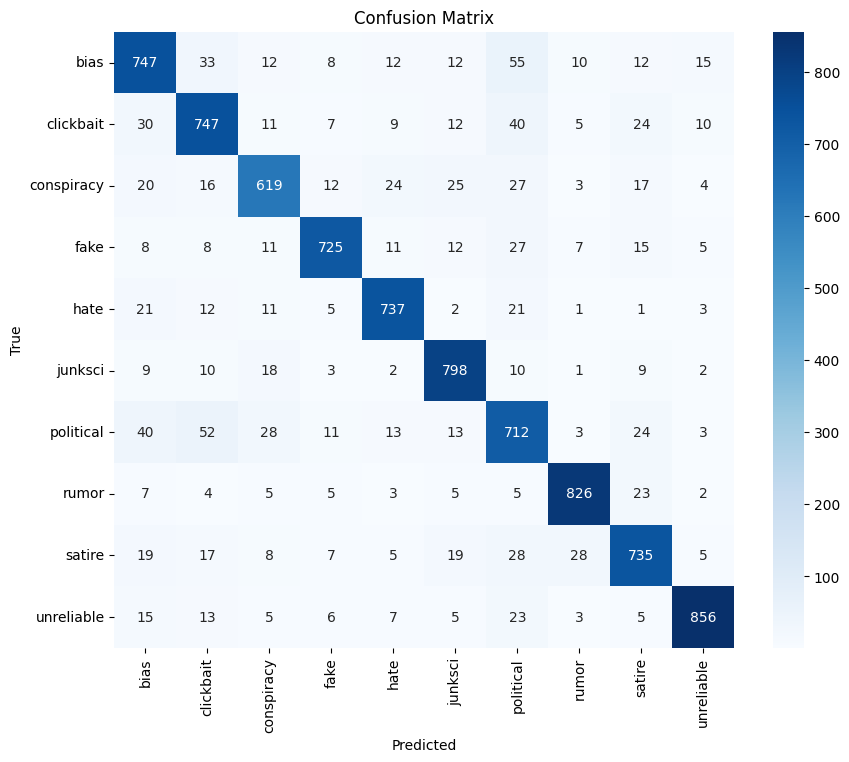

              precision    recall  f1-score   support

        bias       0.82      0.82      0.82       916
   clickbait       0.82      0.83      0.83       895
  conspiracy       0.85      0.81      0.83       767
        fake       0.92      0.87      0.90       829
        hate       0.90      0.91      0.90       814
     junksci       0.88      0.93      0.90       862
   political       0.75      0.79      0.77       899
       rumor       0.93      0.93      0.93       885
      satire       0.85      0.84      0.85       871
  unreliable       0.95      0.91      0.93       938

    accuracy                           0.86      8676
   macro avg       0.87      0.86      0.87      8676
weighted avg       0.87      0.86      0.86      8676


Top Misclassified Pairs:
bias → political: 55 cases
political → clickbait: 52 cases
clickbait → political: 40 cases
political → bias: 40 cases
bias → clickbait: 33 cases


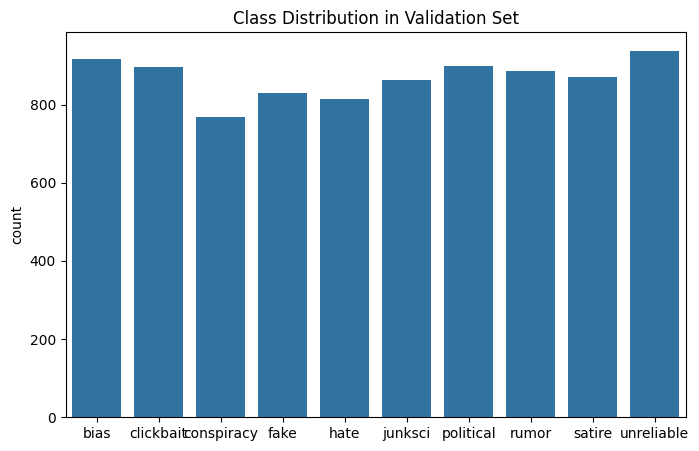

In [48]:
# ===== ADD THIS SECTION AFTER TRAINING =====
# Get predictions and true labels
true_labels, pred_labels = evaluate_with_confusion_matrix(sec_model, val_feature_dl)

# Confusion Matrix
class_names = le.classes_
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Top Misclassified Pairs
errors = np.where(np.array(true_labels) != np.array(pred_labels))[0]
misclassified_pairs = list(zip(np.array(true_labels)[errors], np.array(pred_labels)[errors]))
top_misclassified = Counter(misclassified_pairs).most_common(5)
print("\nTop Misclassified Pairs:")
for (true, pred), count in top_misclassified:
    print(f"{class_names[true]} → {class_names[pred]}: {count} cases")

# Class Distribution Plot
plt.figure(figsize=(8, 5))
sns.countplot(x=true_labels)
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.title('Class Distribution in Validation Set')
plt.show()